<a href="https://colab.research.google.com/github/sankeawthong/Project-1-Lita-Chatbot/blob/main/%5B20241215%5D%20Hybrid%20of%20LR-Bi-LSTM%20for%2010%20class%20without%20FGSM%20on%20NF-ToN-IoT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Hybrid LR-Bi-LSTM for 10 class classifications based on UNSW-NB15 dataset**

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Dropout, Flatten
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from keras.utils import to_categorical

In [2]:
# Load dataset
dataset = pd.read_csv("Dataset_NF-ToN-IoT.csv")

# Preprocessing: Handle missing values (if any)
dataset = dataset.dropna() # Remove missing values

In [3]:
dataset

,L4_SRC_PORT,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label,Attack,Class
0,63318,443,6,91.00,181,165,2,1,24,327,0,Benign,0
1,57442,15600,17,0.00,63,0,1,0,0,0,0,Benign,0
2,57452,15600,17,0.00,63,0,1,0,0,0,0,Benign,0
3,138,138,17,10.16,472,0,2,0,0,0,0,Benign,0
4,51989,15600,17,0.00,63,0,1,0,0,0,0,Benign,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,443,54560,6,91.00,52,52,1,1,17,15,0,Benign,0
1048571,443,54594,6,91.00,52,52,1,1,17,11,0,Benign,0
1048572,443,54582,6,91.00,52,52,1,1,17,11,0,Benign,0
1048573,443,54592,6,91.00,52,52,1,1,17,11,0,Benign,0


### **Data Preprocessing**

In [4]:
# Encode non-numeric columns (if any)
for column in dataset.columns:
    if dataset[column].dtype == 'object':  # Identify categorical columns
        dataset[column] = LabelEncoder().fit_transform(dataset[column])

# Separate features (X) and target (y)
X = dataset.drop(['Class'], axis=1)  # Assuming 'Class' is the target column
y = dataset['Class']

In [5]:
print("Original Class Distribution:", np.bincount(y))

Original Class Distribution: [164866  17243 149605  10732 453506   1249 135353    142  15966  99913]


In [6]:
# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [7]:
!pip install -U imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 4.6 MB/s eta 0:00:00


In [8]:
from imblearn.over_sampling import SMOTE
# Balance dataset using SMOTE
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

# Verify the balanced dataset distribution
print("Balanced Class Distribution:", np.bincount(y))

Balanced Class Distribution: [453506 453506 453506 453506 453506 453506 453506 453506 453506 453506]


In [9]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### **Hybrid combination of LR-Bi-LSTM for 10 class classifications on UNSW-NB15**

LR model Standalone

In [ ]:
# Initialize and train the Logistic Regression model
lr_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=800, random_state=42)
lr_model.fit(X_train, y_train)

# Make predictions
y_pred = lr_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

#print("\nConfusion Matrix:")
#print(confusion_matrix(y_test, y_pred))

Hybrid model with using features results from LR model as Bi-LSTM input

In [10]:
from keras.utils import to_categorical

# Initialize and train the Logistic Regression model
lr_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500, random_state=42)
lr_model.fit(X_train, y_train)

# Extract probabilities from LR model
train_lr_features = lr_model.predict_proba(X_train)  # Features for Bi-LSTM from training data
test_lr_features = lr_model.predict_proba(X_test)    # Features for Bi-LSTM from test data

# Reshape LR features for Bi-LSTM input
train_lr_features = np.expand_dims(train_lr_features, axis=1)
test_lr_features = np.expand_dims(test_lr_features, axis=1)

# Convert labels to one-hot encoding for Bi-LSTM
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [11]:
## Build the Bi-LSTM model

#bilstm_model = Sequential()
#bilstm_model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(1, train_lr_features.shape[2])))
#bilstm_model.add(Dropout(0.5))
#bilstm_model.add(Bidirectional(LSTM(32)))
#bilstm_model.add(Dropout(0.5))
#bilstm_model.add(Dense(10, activation='softmax'))  # 10 classes

#bilstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

from keras.regularizers import l2

bilstm_model = Sequential()
bilstm_model.add(Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.0001)), input_shape=(1, train_lr_features.shape[2])))
bilstm_model.add(Dropout(0.2))
bilstm_model.add(Bidirectional(LSTM(32, kernel_regularizer=l2(0.0001))))
bilstm_model.add(Dropout(0.2))
#bilstm_model.add(Bidirectional(LSTM(16, kernel_regularizer=l2(0.002))))
#bilstm_model.add(Dropout(0.2))
bilstm_model.add(Dense(10, activation='softmax', kernel_regularizer=l2(0.0001)))

bilstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the Bi-LSTM model
history = bilstm_model.fit(train_lr_features, y_train, validation_split=0.2, epochs=50, batch_size=64, verbose=1)

# Evaluate the hybrid model on the test set
test_predictions = bilstm_model.predict(test_lr_features)
test_predictions_labels = np.argmax(test_predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Performance metrics
accuracy = accuracy_score(true_labels, test_predictions_labels)
print("\nHybrid Model Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(true_labels, test_predictions_labels))
print("\nConfusion Matrix:")
print(confusion_matrix(true_labels, test_predictions_labels))

Epoch 1/50
45351/45351 [==============================] - 225s 5ms/step - loss: 0.0250 - accuracy: 0.9997 - val_loss: 0.0153 - val_accuracy: 0.9999
Epoch 2/50
45351/45351 [==============================] - 226s 5ms/step - loss: 0.0156 - accuracy: 0.9999 - val_loss: 0.0152 - val_accuracy: 0.9999
Epoch 3/50
45351/45351 [==============================] - 219s 5ms/step - loss: 0.0156 - accuracy: 0.9999 - val_loss: 0.0152 - val_accuracy: 0.9998
Epoch 4/50
45351/45351 [==============================] - 222s 5ms/step - loss: 0.0156 - accuracy: 0.9999 - val_loss: 0.0152 - val_accuracy: 0.9999
Epoch 5/50
45351/45351 [==============================] - 223s 5ms/step - loss: 0.0156 - accuracy: 0.9999 - val_loss: 0.0153 - val_accuracy: 0.9999
Epoch 6/50
45351/45351 [==============================] - 225s 5ms/step - loss: 0.0156 - accuracy: 0.9999 - val_loss: 0.0152 - val_accuracy: 0.9999
Epoch 7/50
45351/45351 [==============================] - 222s 5ms/step - loss: 0.0156 - accuracy: 0.9999 - val_

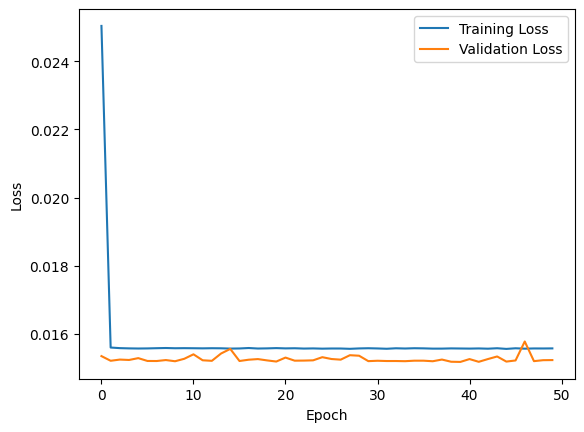

In [12]:
# Plot training and validation loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
# Performance metrics
accuracy = accuracy_score(true_labels, test_predictions_labels)
precision = precision_score(true_labels, test_predictions_labels, average='macro')
recall = recall_score(true_labels, test_predictions_labels, average='macro')
f1 = f1_score(true_labels, test_predictions_labels, average='macro')

print("\nHybrid Model Accuracy:", accuracy)
print("\nPrecision:", precision)
print("\nRecall:", recall)
print("\nF1-Score:", f1)


Hybrid Model Accuracy: 0.9998974655241607

Precision: 0.9998974848142191

Recall: 0.9998974658572181

F1-Score: 0.9998974666520896


In [14]:
# Classification report
print("\nClassification Report:")
print(classification_report(true_labels, test_predictions_labels))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     90701
           1       1.00      1.00      1.00     90701
           2       1.00      1.00      1.00     90701
           3       1.00      1.00      1.00     90702
           4       1.00      1.00      1.00     90701
           5       1.00      1.00      1.00     90701
           6       1.00      1.00      1.00     90702
           7       1.00      1.00      1.00     90701
           8       1.00      1.00      1.00     90701
           9       1.00      1.00      1.00     90701

    accuracy                           1.00    907012
   macro avg       1.00      1.00      1.00    907012
weighted avg       1.00      1.00      1.00    907012



In [16]:
# Detection Rate (Recall for each class)
detection_rate = recall_score(true_labels, test_predictions_labels, average=None)
for i in range(len(detection_rate)):
    print(f"Detection Rate for Class {i}: {detection_rate[i]:.15f}")

Detection Rate for Class 0: 1.000000000000000
Detection Rate for Class 1: 1.000000000000000
Detection Rate for Class 2: 0.999977949526466
Detection Rate for Class 3: 0.999691296774051
Detection Rate for Class 4: 0.999856671922030
Detection Rate for Class 5: 1.000000000000000
Detection Rate for Class 6: 0.999801547926176
Detection Rate for Class 7: 0.999922823342631
Detection Rate for Class 8: 0.999724369080826
Detection Rate for Class 9: 1.000000000000000


In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
def conf_mat(d1,d2):
  cm = confusion_matrix(d1, d2)
  #plt.figure(figsize=(6,5.5))
  plt.figure(figsize=(8,6.5))
  #ax = sns.heatmap(cm,  fmt='2', annot=True, cmap='tab20c')
  ax = sns.heatmap(cm, annot=True, fmt=".0f", cmap="bone",
                 vmin=0, vmax=5600, center=0, square=True, linewidths=1.5)
  sns.set(font_scale=0.8)
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values\n');
  ax.xaxis.set_ticklabels(['Benign','Backdoor','DDoS','DoS','Injection','mitm','Password','Ransomware','Scanning','xss'])
  ax.yaxis.set_ticklabels(['Benign','Backdoor','DDoS','DoS','Injection','mitm','Password','Ransomware','Scanning','xss'])
  plt.xticks(rotation=45)  # Add this line to rotate the x-axis labels by 45 degrees
  plt.yticks(rotation=45)  # Add this line to rotate the x-axis labels by 45 degrees
  plt.tight_layout()
  # plt.savefig("F1.eps", format = 'eps')
  plt.show()

Confusion Matrix of Hybrid LR-BiLSTM Model


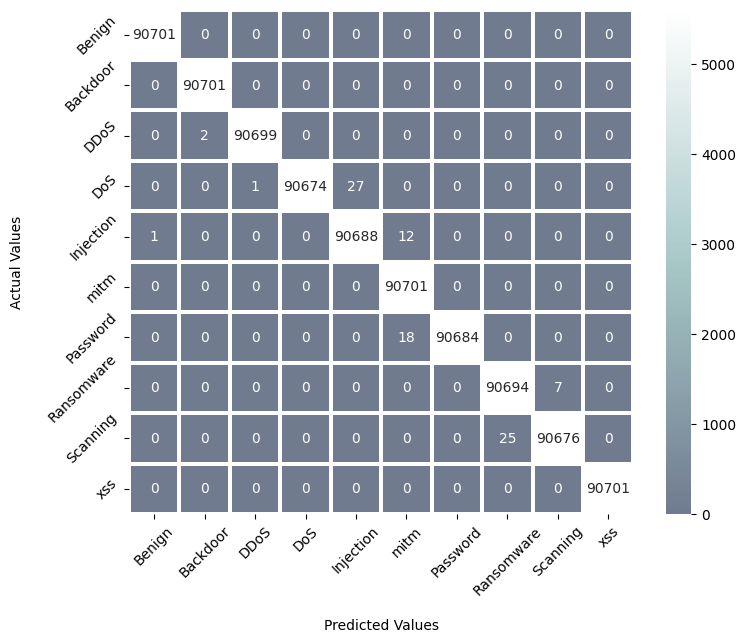

In [18]:
print("Confusion Matrix of Hybrid LR-BiLSTM Model")
conf_mat(true_labels, test_predictions_labels)

**With FGSM adversarial training**

In [ ]:
import tensorflow as tf
from keras.regularizers import l2

#Build the Bi-LSTM model
bilstm_model = Sequential()
bilstm_model.add(Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.0002)), input_shape=(1, train_lr_features.shape[2])))
bilstm_model.add(Dropout(0.5))
bilstm_model.add(Bidirectional(LSTM(32, kernel_regularizer=l2(0.0002))))
bilstm_model.add(Dropout(0.5))
#bilstm_model.add(Bidirectional(LSTM(16, kernel_regularizer=l2(0.002))))
#bilstm_model.add(Dropout(0.2))
bilstm_model.add(Dense(10, activation='softmax', kernel_regularizer=l2(0.0002)))

bilstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# FGSM: Function to generate adversarial examples
def generate_adversarial_examples(model, data, labels, epsilon=0.1):
    data_tensor = tf.convert_to_tensor(data, dtype=tf.float32)
    labels_tensor = tf.convert_to_tensor(labels, dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(data_tensor)
        predictions = model(data_tensor)
        loss = tf.keras.losses.categorical_crossentropy(labels_tensor, predictions)

    gradients = tape.gradient(loss, data_tensor)
    perturbations = epsilon * tf.sign(gradients)
    adversarial_data = data_tensor + perturbations

    return adversarial_data.numpy()

# Generate adversarial examples for training
adversarial_train_features = generate_adversarial_examples(bilstm_model, train_lr_features, y_train)

# Combine original and adversarial examples
combined_train_features = np.concatenate((train_lr_features, adversarial_train_features), axis=0)
combined_train_labels = np.concatenate((y_train, y_train), axis=0)

# Train the Bi-LSTM model
history = bilstm_model.fit(
    combined_train_features, combined_train_labels,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    verbose=1
)

# Evaluate the model
test_predictions = bilstm_model.predict(test_lr_features)
test_predictions_labels = np.argmax(test_predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Metrics and results
accuracy = accuracy_score(true_labels, test_predictions_labels)
print("\nHybrid Model Accuracy with FGSM:", accuracy)
print("\nClassification Report:")
print(classification_report(true_labels, test_predictions_labels))
print("\nConfusion Matrix:")
print(confusion_matrix(true_labels, test_predictions_labels))

In [ ]:
# Plot training and validation loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
# Performance metrics
accuracy = accuracy_score(true_labels, test_predictions_labels)
precision = precision_score(true_labels, test_predictions_labels, average='macro')
recall = recall_score(true_labels, test_predictions_labels, average='macro')
f1 = f1_score(true_labels, test_predictions_labels, average='macro')

print("\nHybrid Model Accuracy:", accuracy)
print("\nPrecision:", precision)
print("\nRecall:", recall)
print("\nF1-Score:", f1)

In [ ]:
# Detection Rate (Recall for each class)
detection_rate = recall_score(true_labels, test_predictions_labels, average=None)
for i in range(len(detection_rate)):
    print(f"Detection Rate for Class {i}: {detection_rate[i]:.10f}")

In [ ]:
#Calculate ROC AUC and plot ROC curves
from sklearn.metrics import roc_curve, roc_auc_score # Import roc_curve and roc_auc_score
import matplotlib.pyplot as plt

roc_aucs = []
for i in range(10):  # Assuming 10 classes
    fpr, tpr, _ = roc_curve(y_test[:, i], test_predictions[:, i])
    roc_auc = roc_auc_score(y_test[:, i], test_predictions[:, i])
    roc_aucs.append(roc_auc)
    plt.plot(fpr, tpr, label=f'Class {i} (area = {roc_auc:.10f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Print results
#print(f"\nHybrid Model Accuracy with FGSM: {accuracy:.10f}")
#print("\nClassification Report:\n", classification_rep)
#print("\nConfusion Matrix:\n", conf_matrix)

# Print results
print(f"\nHybrid Model Accuracy with FGSM: {accuracy:.10f}")
classification_rep = classification_report(true_labels, test_predictions_labels)  # Store the classification report
print("\nClassification Report:\n", classification_rep)
# Assuming 'conf_matrix' will be calculated and assigned similarly:
conf_matrix = confusion_matrix(true_labels, test_predictions_labels)  # Store the confusion matrix
print("\nConfusion Matrix:\n", conf_matrix)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
def conf_mat(d1,d2):
  cm = confusion_matrix(d1, d2)
  #plt.figure(figsize=(6,5.5))
  plt.figure(figsize=(8,6.5))
  #ax = sns.heatmap(cm,  fmt='2', annot=True, cmap='tab20c')
  ax = sns.heatmap(cm, annot=True, fmt=".0f", cmap="bone",
                 vmin=0, vmax=5600, center=0, square=True, linewidths=1.5)
  sns.set(font_scale=0.8)
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values\n');
  ax.xaxis.set_ticklabels(['Benign','Backdoor','DDoS','DoS','Injection','mitm','Password','Ransomware','Scanning','xss'])
  ax.yaxis.set_ticklabels(['Benign','Backdoor','DDoS','DoS','Injection','mitm','Password','Ransomware','Scanning','xss'])
  plt.xticks(rotation=45)  # Add this line to rotate the x-axis labels by 45 degrees
  plt.yticks(rotation=45)  # Add this line to rotate the x-axis labels by 45 degrees
  plt.tight_layout()
  # plt.savefig("F1.eps", format = 'eps')
  plt.show()

In [ ]:
print("Confusion Matrix of Hybrid LR-BiLSTM Model")
conf_mat(true_labels, test_predictions_labels)